In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq

    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [2]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append('/content/drive/MyDrive/')
model_folder = base_folder/'data/models/dl_fall_2023/cifar_10/nov-09'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/CIFAR10'
project_folder.mkdir(parents=True, exist_ok=True)

In [3]:
import yaml

import torch
import torch.nn as nn
import torchvision
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

In [4]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [5]:
# Import torchviso.models
import torchvision.models as models

# Get the pre-trained VGG16 model
model = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]


In [6]:
def count_parameters(model):

  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
print(count_parameters(model))

138357544


In [7]:
# Freeze all the parameters
for param in model.parameters():
    param.requires_grad = False


In [8]:
#function for transformations
train_transform = transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.ToTensor(),
                                            transforms.Resize(size=(224, 224)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
                                      ])

valid_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
                                      ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
                                                     ])

In [9]:
# Loading the data and splitting into train, valid and test
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random
from collections import defaultdict
import pytorch_lightning as pl

class TransformedSubset(Dataset):

    def __init__(self, subset, transform=None):
        self.subset = subset  # The original data subset
        self.transform = transform  # The transform function to apply on the data

    def __getitem__(self, index):
        """
        Retrieve and optionally transform the item (image, label) at the given index.

        Parameters:
        index (int): Index of the item to retrieve.

        Returns:
        tuple: Transformed image and label pair.
        """
        # Retrieve original data
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [10]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./CIFAR10", train_transform=None, test_transform=None,
                 batch_size=64, seed=42, fraction_train=0.8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.seed = seed
        self.fraction_train = fraction_train

    def split_dataset(self, base_dataset):
        split_a_size = int(self.fraction_train * len(base_dataset))
        split_b_size = len(base_dataset) - split_a_size

        return torch.utils.data.random_split(
            base_dataset,
            [split_a_size, split_b_size],
            generator=torch.Generator().manual_seed(self.seed)
        )

    def prepare_data(self):
        # download
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        self.testset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False
        )
        self.predictset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False
        )
        self.train_val_set = datasets.CIFAR10(
            self.data_dir, train=True
        )
        self.trainset, self.validset = self.split_dataset(self.train_val_set)
        self.trainset_transformed = TransformedSubset(self.trainset, self.train_transform)
        self.validset_transformed = TransformedSubset(self.validset, self.test_transform)

    def train_dataloader(self):
        return DataLoader(
            self.trainset_transformed, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(self.validset_transformed, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predictset, batch_size=self.batch_size, shuffle=False)


def get_stratified_subset(dataset, num_samples, seed=None):
    if seed is not None:
        random.seed(seed)

    # Step 1: Identify label distribution
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)

    # Step 2: Calculate proportions and initialize subset indices list
    proportions = {label: len(indices) / len(dataset) for label, indices in label_to_indices.items()}
    subset_indices = []

    # Step 3: Sample according to proportion
    for label, indices in label_to_indices.items():
        num_samples_for_label = round(proportions[label] * num_samples)
        subset_indices += random.sample(indices, num_samples_for_label)

    # Step 4: Combine samples
    return torch.utils.data.Subset(dataset, subset_indices)


In [11]:
#Function to load the model
def load_model(model_config):
    model = models.vgg16(weights="DEFAULT")

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
    model.classifier[0].requires_grad_(True)
    model.classifier[3].requires_grad_(True)
    model.classifier[6].requires_grad_(True)
    return model

In [12]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    dm = CIFAR10DataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

In [13]:
c = 0
for param in model.parameters():
    c+=1
    param.requires_grad = False
    if c>35:
        break

In [14]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


In [15]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



In [16]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [17]:
# Load Lightning Module
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

In [18]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

In [19]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

In [20]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# Running a training and validation batch
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to i

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.29, Val_Metric: 0.12 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.40, Train_Metric: 0.06


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.34, Val_Metric: 0.10 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 45.76, Val_Metric: 0.11 | 

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 19 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0006812920690579612
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_81131b76-d0e9-4613-bfb7-9f944b9c2d7b.ckpt


Train_Loss: 6.03, Train_Metric: 0.28


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_81131b76-d0e9-4613-bfb7-9f944b9c2d7b.ckpt


0.0006812920690579612


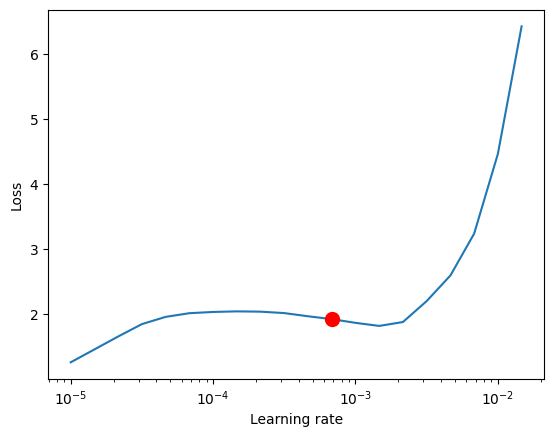

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup(stage='None')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
-----------------

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.42, Val_Metric: 0.85 | Train_Loss: 0.74, Train_Metric: 0.75


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.37, Val_Metric: 0.87 | Train_Loss: 0.47, Train_Metric: 0.83


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.34, Val_Metric: 0.88 | Train_Loss: 0.41, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.33, Val_Metric: 0.88 | Train_Loss: 0.37, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.32, Val_Metric: 0.89 | Train_Loss: 0.36, Train_Metric: 0.88


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


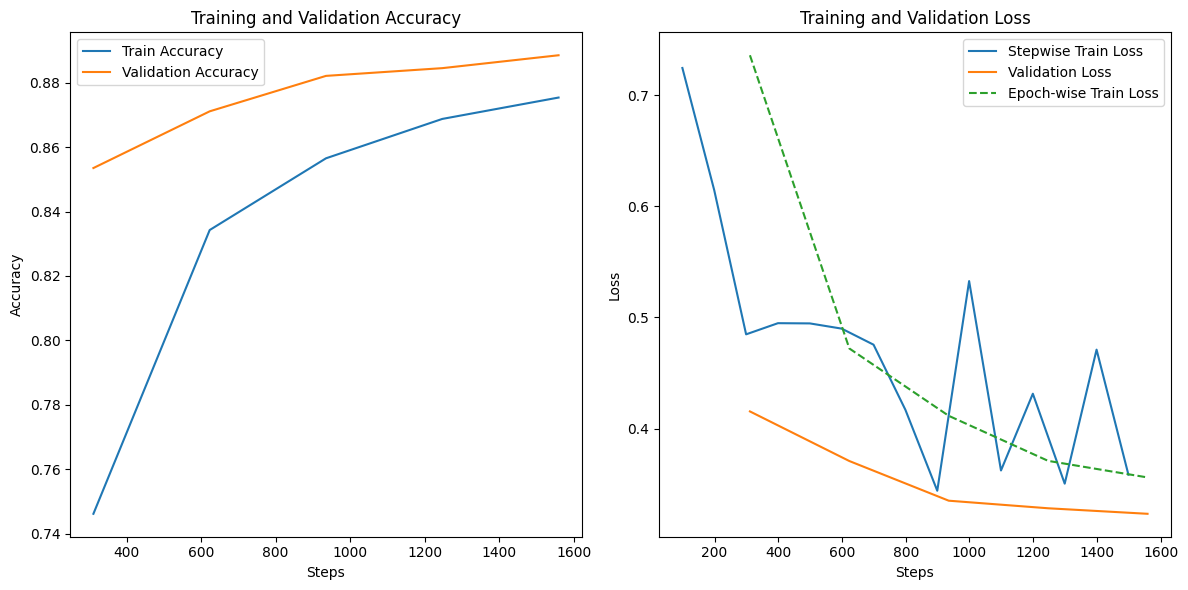

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 wh

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.28, Val_Metric: 0.90 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.32, Val_Metric: 0.89 | Train Accuracy: 90.13
Validation Accuracy: 88.85


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▃▃▃▅▅▅███
train_loss_epoch,█▃▂▁▁
train_loss_step,█▆▄▄▄▄▃▂▁▄▁▃▁▃▁
train_metric,▁▆▇██
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▆▄▃▃▁▃
val_metric,▁▄▅▆▆█▆
epoch,5
learning_rate,6e-05
train_loss_epoch,0.35608


In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.006
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1

lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.001,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate', 'interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

In [ ]:
for name, param in model.named_parameters():
    if 'features.24' in name:
        param.requires_grad = True

In [ ]:
# Check which layers are frozen and which are trainable
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

features.0.weight: False
features.0.bias: False
features.2.weight: False
features.2.bias: False
features.5.weight: False
features.5.bias: False
features.7.weight: False
features.7.bias: False
features.10.weight: False
features.10.bias: False
features.12.weight: False
features.12.bias: False
features.14.weight: False
features.14.bias: False
features.17.weight: False
features.17.bias: False
features.19.weight: False
features.19.bias: False
features.21.weight: False
features.21.bias: False
features.24.weight: True
features.24.bias: True
features.26.weight: False
features.26.bias: False
features.28.weight: False
features.28.bias: False
classifier.0.weight: True
classifier.0.bias: True
classifier.3.weight: True
classifier.3.bias: True
classifier.6.weight: True
classifier.6.bias: True


INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
-----------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transf

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.41, Val_Metric: 0.86 | Train_Loss: 0.62, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.36, Val_Metric: 0.87 | Train_Loss: 0.45, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


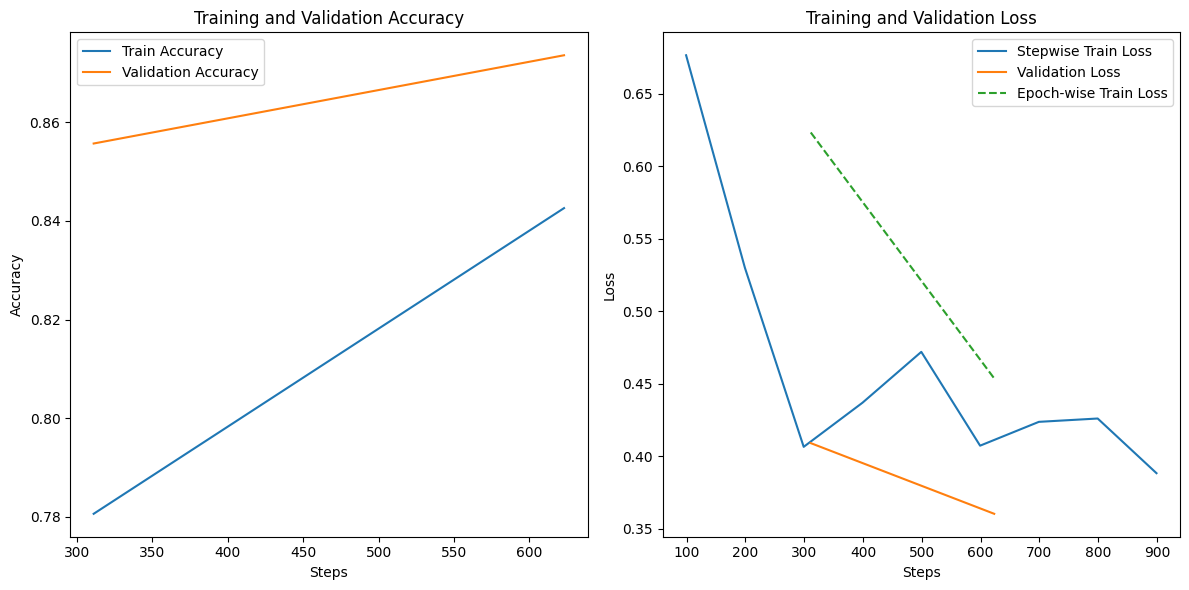

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is t

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 3: Val_Loss: 0.37, Val_Metric: 0.87 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.36, Val_Metric: 0.87 | Train Accuracy: 87.13
Validation Accuracy: 87.36


epoch,▁▁▁▁▁▅▅▅▅▅█████
learning_rate,▁▁▁▃▃▃███
train_loss_epoch,█▁
train_loss_step,█▄▁▂▃▁▂▂▁
train_metric,▁█
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▇▇████
val_loss,█▁▂▁
val_metric,▁█▇█
epoch,2
learning_rate,0.00018
train_loss_epoch,0.45378


In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1

lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.004,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate', 'interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

In [ ]:
# prompt: Adjust the VGG16 model to unfreeze from the last two CNN blocks (i.e., features [17] onwards).

for name, param in model.named_parameters():
    if 'features.17' in name:
        param.requires_grad = True


INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
-----------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transf

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.41, Val_Metric: 0.86 | Train_Loss: 0.62, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.36, Val_Metric: 0.87 | Train_Loss: 0.45, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.37, Val_Metric: 0.87 | Train_Loss: 0.41, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.35, Val_Metric: 0.88 | Train_Loss: 0.39, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.33, Val_Metric: 0.88 | Train_Loss: 0.40, Train_Metric: 0.86


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


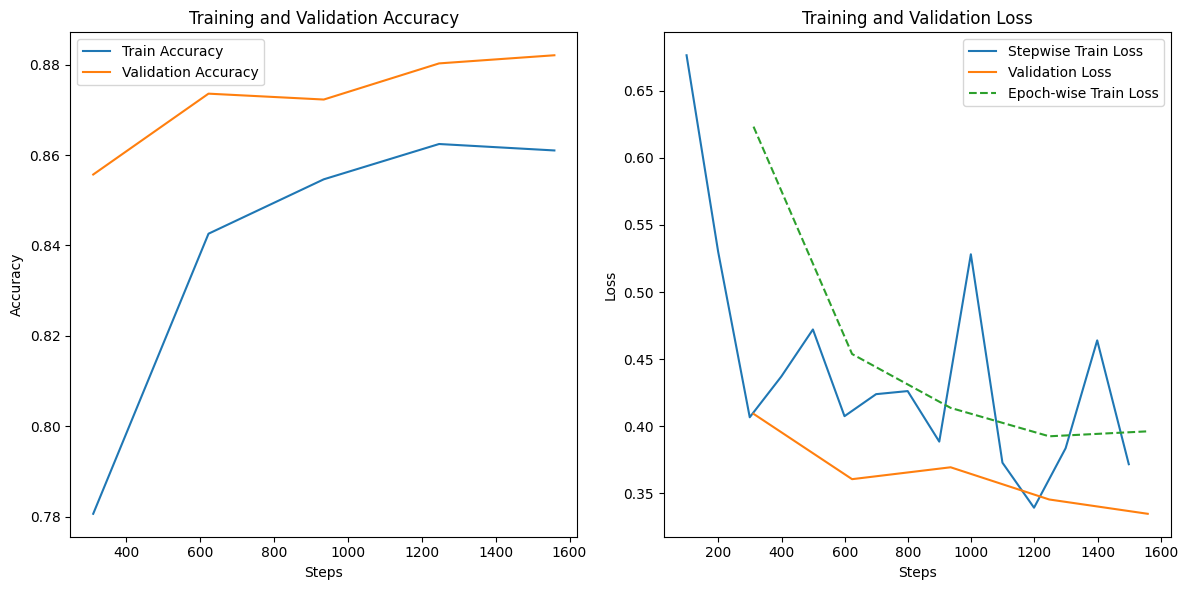

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v2.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 wh

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.30, Val_Metric: 0.90 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=4-step=1560-v2.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.33, Val_Metric: 0.88 | Train Accuracy: 89.70
Validation Accuracy: 88.21


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▃▃▃▅▅▅███
train_loss_epoch,█▃▂▁▁
train_loss_step,█▅▂▃▄▂▃▃▂▅▂▁▂▄▂
train_metric,▁▆▇██
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▅▅▄▃▁▃
val_metric,▁▄▄▅▅█▅
epoch,5
learning_rate,0.00026
train_loss_epoch,0.39613


In [ ]:

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1

lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.004,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate', 'interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()


In [ ]:
# experimenting with different learning rates.

In [24]:
import torch.optim as optim

In [ ]:
# Define different learning rates for different layers or groups of parameters
layer_learning_rates = [
    {'params': model.features[:10].parameters(), 'lr': 0.001},
    {'params': model.features[10:].parameters(), 'lr': 0.005},
]

In [ ]:
optimizer = optim.Adam(layer_learning_rates, weight_decay=1)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: navya-190997. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:263: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'anneal-strategy'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | mo

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transf

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.40, Val_Metric: 0.86 | Train_Loss: 0.62, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.36, Val_Metric: 0.87 | Train_Loss: 0.46, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.37, Val_Metric: 0.87 | Train_Loss: 0.43, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.34, Val_Metric: 0.88 | Train_Loss: 0.40, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.34, Val_Metric: 0.88 | Train_Loss: 0.42, Train_Metric: 0.86


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


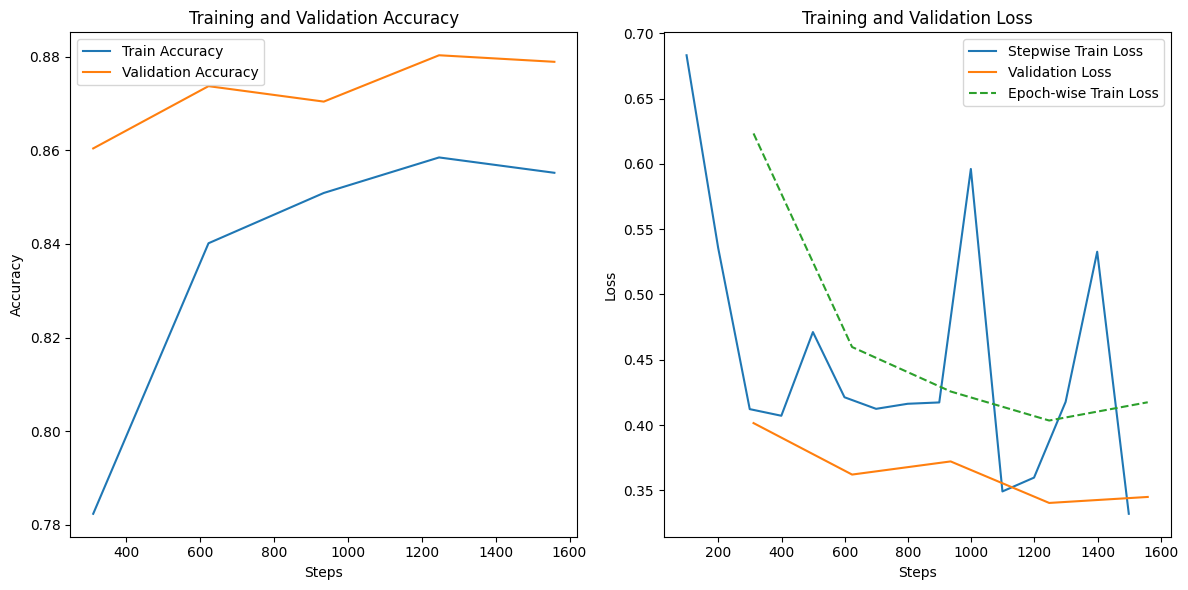

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 wh

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.32, Val_Metric: 0.89 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.34, Val_Metric: 0.88 | Train Accuracy: 89.03
Validation Accuracy: 88.03


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▃▃▃▅▅▅███
train_loss_epoch,█▃▂▁▁
train_loss_step,█▅▃▂▄▃▃▃▃▆▁▂▃▅▁
train_metric,▁▆▇██
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▅▆▃▃▁▃
val_metric,▁▄▃▆▅█▆
epoch,5
learning_rate,0.00032
train_loss_epoch,0.41745


In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['optimizer'] = optimizer
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.005,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate','anneal-strategy':'linear','interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

In [ ]:
params_bias = []
params_wts = []

# seperate the bias and weights parameters
for name, parameter in model.named_parameters():
  if "bias" in name:
    params_bias.append(parameter)
  elif "weight" in name:
    params_wts.append(parameter)

# Set the optimiser to have different hyperparameters for bias and weights
optimiser = torch.optim.SGD([{"params": params_bias, 'lr' : 0.005, "momentum" : 0.99},
                             {"params": params_wts}], lr = 0.05, momentum = 0.9)

In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['optimizer'] = optimiser
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.005,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate','anneal-strategy':'linear','interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:263: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'anneal-strategy'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | mo

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transf

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.40, Val_Metric: 0.86 | Train_Loss: 0.62, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.36, Val_Metric: 0.87 | Train_Loss: 0.46, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

In [ ]:
#Resnet Model

In [ ]:
import torchvision.models as models
def load_model(config):
    model = models.resnet34(weights='DEFAULT')

    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer3.parameters():
        param.requires_grad = True

    for param in model.layer4.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(512, config['output_size'],bias=True)
    return model

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:263: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'anneal-strategy'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | mo

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.77, Val_Metric: 0.09 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.23, Val_Metric: 0.92 | Train_Loss: 0.37, Train_Metric: 0.88


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.20, Val_Metric: 0.94 | Train_Loss: 0.20, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.20, Val_Metric: 0.93 | Train_Loss: 0.17, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.22, Val_Metric: 0.93 | Train_Loss: 0.17, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.26, Val_Metric: 0.91 | Train_Loss: 0.18, Train_Metric: 0.94


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


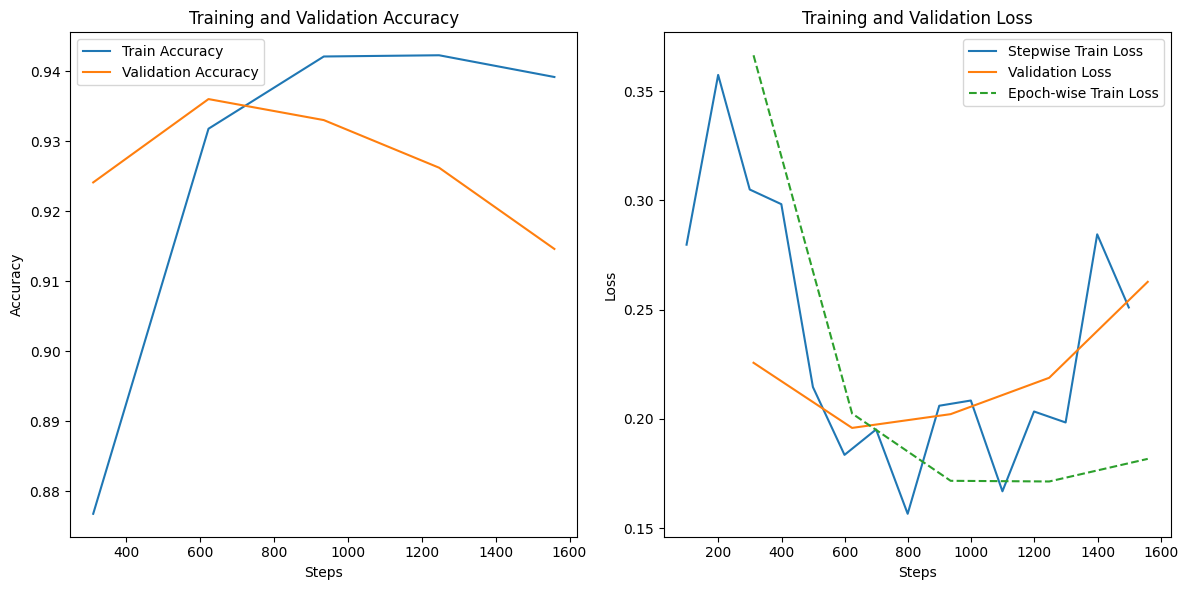

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is t

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.14, Val_Metric: 0.95 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=1-step=624.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.20, Val_Metric: 0.94 | Train Accuracy: 95.29
Validation Accuracy: 93.60


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▃▃▃▅▅▅███
train_loss_epoch,█▂▁▁▁
train_loss_step,▅█▆▆▃▂▂▁▃▃▁▃▂▅▄
train_metric,▁▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,▆▄▄▅█▁▄
val_metric,▃▅▄▃▁█▅
epoch,5
learning_rate,0.00032
train_loss_epoch,0.18174


In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['optimizer'] = optimizer
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.005,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}
# Model config
model_config = {'output_size': 10}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate','anneal-strategy':'linear','interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

In [ ]:
# Convexnet Model

In [22]:
model = models.convnext_tiny(weights="IMAGENET1K_V1")
model.classifier[2] = nn.Linear(768, out_features=10,bias='True')

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


100%|██████████| 170498071/170498071 [00:15<00:00, 11196800.92it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:263: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'anneal-strategy'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | mo

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transf

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.40, Val_Metric: 0.86 | Train_Loss: 0.62, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.36, Val_Metric: 0.87 | Train_Loss: 0.46, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.37, Val_Metric: 0.87 | Train_Loss: 0.43, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.34, Val_Metric: 0.88 | Train_Loss: 0.40, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.34, Val_Metric: 0.88 | Train_Loss: 0.42, Train_Metric: 0.86


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


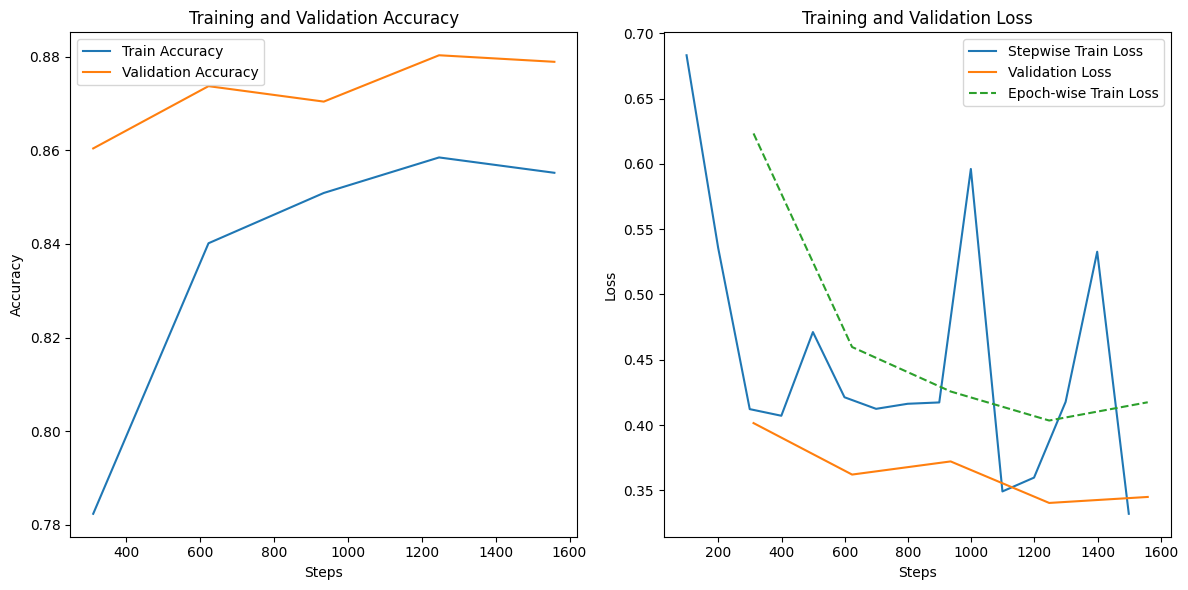

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v3.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 wh

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val_Loss: 0.32, Val_Metric: 0.89 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/cifar_10/nov-09/logs/epoch=3-step=1248-v3.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.34, Val_Metric: 0.88 | Train Accuracy: 89.03
Validation Accuracy: 88.03


epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▃▃▃▅▅▅███
train_loss_epoch,█▃▂▁▁
train_loss_step,█▅▃▂▄▃▃▃▃▆▁▂▃▅▁
train_metric,▁▆▇██
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▅▆▃▃▁▃
val_metric,▁▄▃▆▅█▆
epoch,5
learning_rate,0.00032
train_loss_epoch,0.41745


In [27]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config,trainer_config = load_all_configs()
# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['log_every_n_steps']=100
trainer_config['max_epochs']=5
lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['optimizer'] = optimizer
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {'max_lr': 0.005,'verbose':False,'steps_per_epoch':50,
                                               'epochs': 2,'pct_start':0.4,'div_factor':25,'final_div_factor':1e4}
# Model config
model_config = {'output_size': 10}

lightning_module_config['scheduler_options'] = {'monitor': 'val_loss','name':'learning_rate','anneal-strategy':'linear','interval':'epoch','frequency':1}
model, dm, lightning_module, trainer = load_components(model_config,data_module_config,lightning_module_config,data_folder, trainer_config,
cl_config,batch_size=data_module_config['data_module']['batch_size'],
logging=True,checkpointing=True, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(),ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(),ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()